# Modelling Extreme values for the Wind Farm project

This notebook is a brief example of the possibilities offered by the toolbox for modeling extreme values, adapted from the tools provided from the ResourceCode website.

It relies on the `pyextreme` library which get installed with the Resourcecode toolbox. Here we demonstrate 2 examples of univariate modeling as shown in class. For more information, see https://georgebv.github.io/pyextremes/.

# 1. Wave Dynamics

## 1.1 Characterizing the study site mean wave conditions

This notebook covers Part I.A of the wind turbine project: Characterizing the mean wave conditions and seasonal variability at the selected study site. The goal is to analyze long-term hindcast data to understand the typical and seasonal wave climate.

---

### Import Required Libraries




In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import (
    plot_mean_residual_life,
    plot_parameter_stability, 
    EVA
)
import resourcecode

from resourcecode.eva import (
    censgaussfit,
    get_fitted_models,
    get_gpd_parameters,
    run_simulation,
    huseby,
)
import warnings
warnings.filterwarnings("ignore")

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

---
### Chosen Study Site

**Site:** Bretagne Sud 1
**Coordinates:** $(47.5882, -3.3215)$



In [141]:
client = resourcecode.Client()
# load the resourcecode dataset from Bretagne Sud 1
# find the closest point to the coordinates
point_id, dist_m = resourcecode.data.get_closest_point(latitude=47.5882, longitude=-3.3215)
print(point_id, dist_m)

# get the data from the closest point
data = client.get_dataframe_from_criteria("""
{
    "node": """ + str(point_id) + """,
    "start": 0,
    "end": 99999903600,
    "parameter": ["hs","uwnd","vwnd", "t02", "dpt", "dir"]
}
""")
# compute wind speed and dircetion from u and v vector components
data["wspd"], data["wdir"] = resourcecode.utils.zmcomp2metconv(data.uwnd, data.vwnd)
data.tail()

126096 238.69


,hs,uwnd,vwnd,t02,dpt,dir,wspd,wdir
2020-12-31 19:00:00,1.088,2.4,-4.1,4.51,32.0,245.5,4.750789,329.656751
2020-12-31 20:00:00,1.046,2.1,-3.2,4.69,31.0,245.1,3.827532,326.725112
2020-12-31 21:00:00,0.998,1.7,-1.8,4.94,30.0,244.7,2.475884,316.636577
2020-12-31 22:00:00,0.952,0.3,-0.9,5.13,29.5,244.2,0.948683,341.565051
2020-12-31 23:00:00,0.914,-1.5,-0.5,5.24,29.5,243.8,1.581139,71.565051


In [142]:
data.tail()

,hs,uwnd,vwnd,t02,dpt,dir,wspd,wdir
2020-12-31 19:00:00,1.088,2.4,-4.1,4.51,32.0,245.5,4.750789,329.656751
2020-12-31 20:00:00,1.046,2.1,-3.2,4.69,31.0,245.1,3.827532,326.725112
2020-12-31 21:00:00,0.998,1.7,-1.8,4.94,30.0,244.7,2.475884,316.636577
2020-12-31 22:00:00,0.952,0.3,-0.9,5.13,29.5,244.2,0.948683,341.565051
2020-12-31 23:00:00,0.914,-1.5,-0.5,5.24,29.5,243.8,1.581139,71.565051



---
### Data Source

The analysis will use long-term (1994-2020) hindcast simulations from the **ResourceCode wave database**.

**Variables to download**:
* Significant wave height ($H_{m0}$)
* Mean wave period ($T_{m02}$)
* Mean wave direction
* Wind velocity
* Current velocity





In [143]:
# lets investigate the dataset
# can we locate our point in the dataset?
# lets add direction, signifcant wave period, and wind speed to the dataset



---
### 1. Mean Wave Conditions

First, we will load and plot the 26-year time series (1994-2020) for significant wave height, mean wave period, and mean wave direction. We will also calculate the mean value for each variable over the entire time series.





### 1.1 Block Maxima (BM) Method

**Approach:**  
This approach involves dividing the long-term time series of significant wave heights into non-overlapping blocks of equal duration, typically one year.

**Process:**  
The single highest significant wave height (Hₘ₀) is taken from each block (e.g., the annual maximum).

**Distribution:**  
These maximum values are then fitted to a *Generalized Extreme Value (GEV)* distribution.

**Outcome:**  
This model allows you to estimate the wave height corresponding to a specific return period, such as the 1-year or 50-year storm.

In [144]:
# resample the data into 1 year blocks and extract the maximum value from each block by using pyextremes
model = EVA(data.hs)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=0.9,
)


Lets check the directions of the extreme heights

In [145]:
# lets find the directions of the extremes from the data
data_extreme_directions = data.loc[model.extremes.index, "dir"]
data_extreme_tm02 = data.loc[model.extremes.index, "t02"]




In [146]:
model.extremes.head()

date-time
1994-02-03 19:00:00    6.164
1995-09-07 14:00:00    7.448
1996-02-07 16:00:00    6.550
1997-11-09 12:00:00    5.766
1998-01-04 19:00:00    6.416
Name: hs, dtype: float64

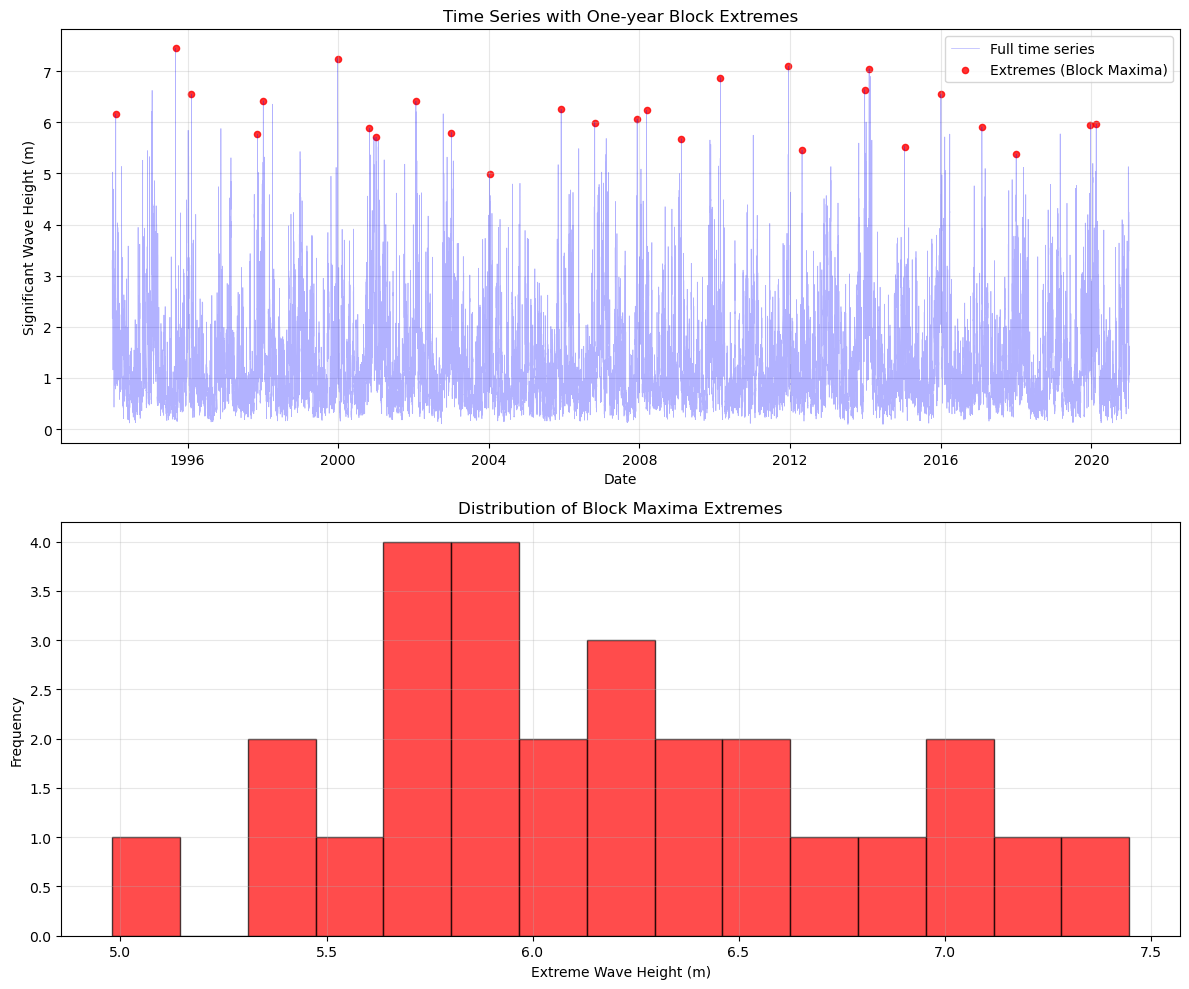

Number of extremes: 27
Mean extreme value: 6.184 m
Maximum extreme value: 7.448 m
Minimum extreme value: 4.980 m
Standard deviation: 0.606 m


In [147]:
# Manual plotting of extremes using matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Time series with extremes highlighted
ax1.plot(data.index, data.hs, 'b-', alpha=0.3, linewidth=0.5, label='Full time series')
ax1.scatter(model.extremes.index, model.extremes.values, color='red', s=20, alpha=0.8, label='Extremes (Block Maxima)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Significant Wave Height (m)')
ax1.set_title('Time Series with One-year Block Extremes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram of extremes
ax2.hist(model.extremes.values, bins=15, alpha=0.7, color='red', edgecolor='black')
ax2.set_xlabel('Extreme Wave Height (m)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Block Maxima Extremes')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the extremes
print(f"Number of extremes: {len(model.extremes)}")
print(f"Mean extreme value: {model.extremes.mean():.3f} m")
print(f"Maximum extreme value: {model.extremes.max():.3f} m")
print(f"Minimum extreme value: {model.extremes.min():.3f} m")
print(f"Standard deviation: {model.extremes.std():.3f} m")



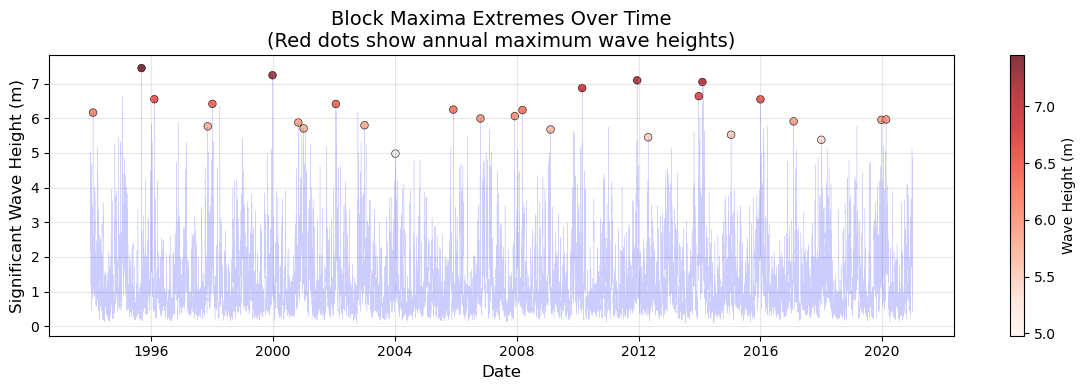

In [148]:
# More detailed manual plotting of extremes
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Plot the full time series
ax.plot(data.index, data.hs, 'b-', alpha=0.2, linewidth=0.3, label='Full time series')

# Highlight extremes with different colors based on magnitude
extremes = model.extremes
colors = plt.cm.Reds(np.linspace(0.3, 1, len(extremes)))
scatter = ax.scatter(extremes.index, extremes.values, c=extremes.values, 
                    cmap='Reds', s=30, alpha=0.8, edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Wave Height (m)')

# Customize the plot
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Significant Wave Height (m)', fontsize=12)
ax.set_title('Block Maxima Extremes Over Time\n(Red dots show annual maximum wave heights)', fontsize=14)
ax.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()


In [149]:
# lets execute GEV fit on the extremes
model.fit_model()


In [150]:
# lets save the diagnostic plot to folder graphs in the current directory   
model.plot_diagnostic(alpha=0.95)
plt.savefig('graphs/diagnostic_plot.png')


In [151]:
extremes_indices = model.extremes.index

df_extremes = data.loc[extremes_indices]
df_extremes.head()
# save as csv
df_extremes.to_csv('data/df_extremes_BM.csv')

In [152]:
# lets compute the mean values
mean_hs = data['hs'].mean()
mean_dir = data['dir'].mean()
mean_tm02 = data['Tm02'].mean()

print(f'Mean significant wave height: {mean_hs:.3f} m')
print(f'Mean wave direction: {mean_dir:.3f} degrees')
print(f'Mean wave period: {mean_tm02:.3f} seconds')

# lets plot the mean values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['hs'], label='Significant Wave Height')




KeyError: 'Tm02'

In [ ]:
# Lets check the mean values for the first 10 years
year_range_first_10y = [i for i in range(1994, 2004)]
data_first_10y = data[data.index.year.isin(year_range_first_10y)]

# Calculate means for first 10 years
mean_hs_first_10y = data_first_10y['hs'].mean()
mean_dir_first_10y = data_first_10y['dir'].mean() 
mean_tm02_first_10y = data_first_10y['t02'].mean()

print(f'Mean significant wave height for first 10 years: {mean_hs_first_10y:.3f} m')
print(f'Mean wave direction for first 10 years: {mean_dir_first_10y:.3f} degrees')
print(f'Mean wave period for first 10 years: {mean_tm02_first_10y:.3f} seconds')

# Lets check the mean values for the last 10 years
year_range_last_10y = [i for i in range(2010, 2020)]
data_last_10y = data[data.index.year.isin(year_range_last_10y)]

# Calculate means for last 10 years
mean_hs_last_10y = data_last_10y['hs'].mean()
mean_dir_last_10y = data_last_10y['dir'].mean()
mean_tm02_last_10y = data_last_10y['t02'].mean()

print(f'Mean significant wave height for last 10 years: {mean_hs_last_10y:.3f} m')
print(f'Mean wave direction for last 10 years: {mean_dir_last_10y:.3f} degrees')
print(f'Mean wave period for last 10 years: {mean_tm02_last_10y:.3f} seconds')

# lets compare these values to the mean values of the entire time series
print(f'Mean significant wave height: {mean_hs:.3f} m')
print(f'Mean wave direction: {mean_dir:.3f} degrees')
print(f'Mean wave period: {mean_tm02:.3f} seconds')


Mean significant wave height for first 10 years: 1.301 m
Mean wave direction for first 10 years: 233.382 degrees
Mean wave period for first 10 years: 4.554 seconds
Mean significant wave height for last 10 years: 1.268 m
Mean wave direction for last 10 years: 237.718 degrees
Mean wave period for last 10 years: 4.638 seconds
Mean significant wave height: 1.273 m
Mean wave direction: 235.274 degrees
Mean wave period: 194.452 seconds


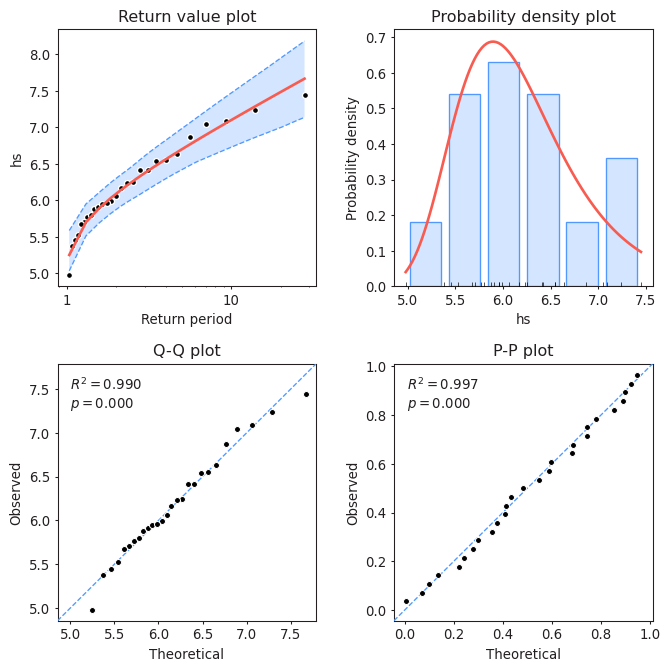

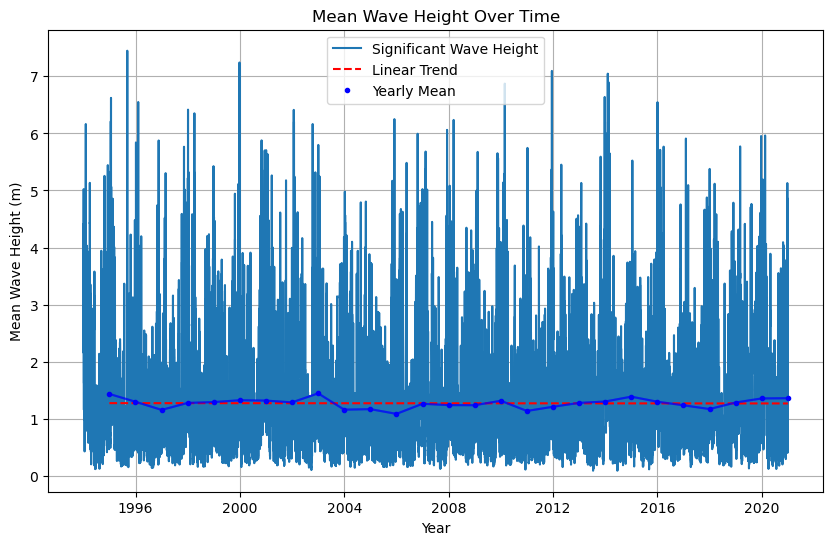


Slope of linear trend: -0.000215 meters/year


In [ ]:
# lets plot the mean values for height, direction and period over time
# resample data to yearly mean values
data_yearly = data.resample('Y').mean()

# lets plot the mean wave height over time and add a linear fit
# Add linear fit
z = np.polyfit(range(len(data_yearly['hs'])), data_yearly['hs'], 1)
p = np.poly1d(z)
plt.plot(data_yearly.index, p(range(len(data_yearly['hs']))), "r--", label='Linear Trend')
plt.xlabel('Year')
plt.ylabel('Mean Wave Height (m)')
plt.title('Mean Wave Height Over Time')
plt.grid(True)

# Plot actual values
plt.plot(data_yearly.index, data_yearly['hs'], 'b.', label='Yearly Mean')

# Calculate R-squared
y_actual = data_yearly['hs']
y_pred = p(range(len(data_yearly['hs'])))
r_squared = 1 - (np.sum((y_actual - y_pred)**2) / np.sum((y_actual - y_actual.mean())**2))

plt.legend()
# Connect the dots between points
plt.plot(data_yearly.index, data_yearly['hs'], 'b-', alpha=0.5)


# Connect the dots between points
plt.plot(data_yearly.index, data_yearly['hs'], 'b-', alpha=0.5)
plt.legend()
plt.savefig('graphs/yearly_mean_hs_over_time.png')
plt.show()
# Print the slope of the linear trend (first coefficient of the polynomial)
print(f"\nSlope of linear trend: {z[0]:.6f} meters/year")


**Q: Do any trends in the wave height, period, or direction exist over the 26 year time period? Do you expect there to be changes in the mean conditions during the 30-year lifetime of the wind turbine? If so, why?**

Wave height: While the linear fit suggests no long-term linear trend, it doesn't mean the conditions were unchanging. The plot highlights substantial interannual variability around a relatively stable long-term average, as the linear fit slope is almost 0. 

In [ ]:
import pymannkendall as mk

data_yearly = data.resample('Y').mean()
result_hs  = mk.original_test(data_yearly['hs'], alpha=0.05)
result_period = mk.original_test(data_yearly['t02'], alpha=0.050)
result_direction = mk.original_test(data_yearly['dir'], alpha=0.05)




print("\nResults for Significant Wave Height (Hs):")
print(f"  Trend: {result_hs.trend}")
print(f"  H (Test Statistic): {result_hs.h}")
print(f"  P-value: {result_hs.p:.4f}")
print(f"  Z-Score: {result_hs.z:.4f}")
print(f"  Tau: {result_hs.Tau:.4f}")
print(f"  Sen's Slope: {result_hs.slope:.4f}")
print(f"  Intercept: {result_hs.intercept:.4f}")

print("\nResults for Wave Period (Tm02):")
print(f"  Trend: {result_period.trend}")
print(f"  H (Test Statistic): {result_period.h}")
print(f"  P-value: {result_period.p:.4f}")
print(f"  Z-Score: {result_period.z:.4f}")
print(f"  Tau: {result_period.Tau:.4f}")
print(f"  Sen's Slope: {result_period.slope:.4f}")
print(f"  Intercept: {result_period.intercept:.4f}")

print("\nResults for Wave Direction:")
print(f"  Trend: {result_direction.trend}")
print(f"  H (Test Statistic): {result_direction.h}")
print(f"  P-value: {result_direction.p:.4f}")
print(f"  Z-Score: {result_direction.z:.4f}")
print(f"  Tau: {result_direction.Tau:.4f}")
print(f"  Sen's Slope: {result_direction.slope:.4f}")
print(f"  Intercept: {result_direction.intercept:.4f}")



Results for Significant Wave Height (Hs):
  Trend: no trend
  H (Test Statistic): False
  P-value: 0.9335
  Z-Score: 0.0834
  Tau: 0.0142
  Sen's Slope: 0.0001
  Intercept: 1.2852

Results for Wave Period (Tm02):
  Trend: no trend
  H (Test Statistic): False
  P-value: 0.0500
  Z-Score: 1.9596
  Tau: 0.2707
  Sen's Slope: 0.0065
  Intercept: 4.4897

Results for Wave Direction:
  Trend: increasing
  H (Test Statistic): True
  P-value: 0.0218
  Z-Score: 2.2932
  Tau: 0.3162
  Sen's Slope: 0.1854
  Intercept: 232.9011


In [ ]:
extremes_indices = model.extremes.index

df_extremes = data.loc[extremes_indices]
df_extremes.head()
# save as csv
df_extremes.to_csv('data/df_extremes_BM.csv')


---
### 2. Most Common Wave Conditions

To identify the most common operating conditions, we will create a 2D histogram (scatter diagram) of significant wave height ($H_{m0}$) versus mean wave period ($T_{m02}$). We will also plot a wave rose to identify the most common wave incidence direction(s).









In [ ]:
# Create 2D histogram/density plot
# bring tso2 to seconds


plt.figure(figsize=(10,8))
plt.hist2d(data['hs'], data['t02'], bins=50, cmap='Blues', density=True)
plt.colorbar(label='Density')
plt.xlabel('Significant Wave Height $H_s$ [m]')
plt.ylabel('Mean Wave Period $T_{m02}$ [s]')
plt.title('Wave Height vs Period Density Plot')
plt.savefig('graphs/wave_height_period_density.png')
plt.close()
plt.show()



**Q: What is the water depth at this location? Indicate on the histrogram for what wave conditions the waves are considered deep water waves? linear waves?**


---
### 3. Seasonal Variability

Next, we will evaluate temporal variability by calculating and plotting the mean wave height, period, and direction as a function of the month of the year (e.g., mean for January, February, etc.).






**Q: Do you observe any seasonal trends in wave height, period, or direction? If so, why?**



---
### 4. Mean Wind and Current Conditions

We will also evaluate the wind and current conditions by plotting rose diagrams of their respective velocities and directions.


**Q: What are the mean conditions (e.g. velocity and direction)? (if you have time: do you observe any seasonal variability?)**


---
### 5. Comparison to Wave Buoy Measurements

We can validate the ResourceCode hindcast data against observations from a nearby wave buoy, for example, from the Candhis website.






**Q: Comparing the hindcast data from ResourceCode to the observations during the time period with overlapping data, what is the RMSD in the wave height, period, and direction between the observations and simulations?**

---
### Report Submission Note

The results from this analysis (Part I.A) and the extreme wave analysis (Part I.B) will be compiled into a concise report due on 24/10/2025.

In [ ]:
'''import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyextremes import (
    plot_mean_residual_life,
    plot_parameter_stability, 
    EVA
)
import resourcecode

from resourcecode.eva import (
    censgaussfit,
    get_fitted_models,
    get_gpd_parameters,
    run_simulation,
    huseby,
)
import warnings
warnings.filterwarnings("ignore")

# Enable inline plotting for Jupyter notebooks
%matplotlib inline'''

'import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom pyextremes import (\n    plot_mean_residual_life,\n    plot_parameter_stability, \n    EVA\n)\nimport resourcecode\n\nfrom resourcecode.eva import (\n    censgaussfit,\n    get_fitted_models,\n    get_gpd_parameters,\n    run_simulation,\n    huseby,\n)\nimport warnings\nwarnings.filterwarnings("ignore")\n\n# Enable inline plotting for Jupyter notebooks\n%matplotlib inline'

We first load the data from the Bretagne Sud 1 location `126096` (coordinates: $(47.5882, -3.3215)$).

In [ ]:
'''point_id, dist_m = resourcecode.data.get_closest_point(latitude=47.5882, longitude=-3.3215)
print(point_id, dist_m)'''

'point_id, dist_m = resourcecode.data.get_closest_point(latitude=47.5882, longitude=-3.3215)\nprint(point_id, dist_m)'

In [ ]:
'''client = resourcecode.Client()
data = client.get_dataframe_from_criteria(
    """
{
    "node": 126096,
    "start": 0,
    "end": 99999903600,
    "parameter": ["hs","uwnd","vwnd"]
}
"""
)'''

'client = resourcecode.Client()\ndata = client.get_dataframe_from_criteria(\n    """\n{\n    "node": 126096,\n    "start": 0,\n    "end": 99999903600,\n    "parameter": ["hs","uwnd","vwnd"]\n}\n"""\n)'

In [ ]:
#data.head()

From the $u$ and $v$ components of the wind, calculate the wind speed and direction.

In [ ]:
#data["wspd"], data["wdir"] = resourcecode.utils.zmcomp2metconv(data.uwnd, data.vwnd)

In [ ]:
#data.head()

### Modelling univariate time series: Block maxima + GEVD (Generalized Extreme Value Distribution)

We show as an example here a **BM** (block maxima) model fitted to the $H_s$ time series. In this approach, the maximum value is identified within a "block" or fixed period in time, and then a GEVP distribution is fit to the data to estimate the return values.  

The same plot can readily be obtained for the other sea-state parameters.

After loading the data, apply the block method approach with a block size of 1 year (365.2425 days), where each data block must be at least 90% full to take into account in the analysis.

In [ ]:
'''#model = EVA(data.hs)
model.get_extremes(method="BM", block_size="365.2425D", min_last_block=0.9)'''

'#model = EVA(data.hs)\nmodel.get_extremes(method="BM", block_size="365.2425D", min_last_block=0.9)'

In [ ]:
#model.extremes.head()

In [ ]:
#model.plot_extremes()

In [ ]:
'''model.fit_model()'''

'model.fit_model()'

The parameter alpha specifies the confidence limits (default = 0.95).

In [ ]:
'''model.plot_diagnostic(alpha=0.95)'''

'model.plot_diagnostic(alpha=0.95)'

The parameter n_samples indicates the number of bootstrap samples used to estimate the confidence bounds.

In [ ]:
'''summary = model.get_summary(
        return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
        alpha=0.95,
        n_samples=1000,
    )
print(summary)'''

'summary = model.get_summary(\n        return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],\n        alpha=0.95,\n        n_samples=1000,\n    )\nprint(summary)'

### Modelling univariate time series: Peaks over threshold (POT) + GPD (Generalized Pareto Distribution)

We show as example here a **POT** (peaks over threshold) model fitted to the $H_s$ time series. This analysis first finds values over a specified threshold and then declusters these values using a predefined clustering distance, and finally finds the maximum value within each cluster. 

The same plot can readily be obtained for the other sea-state parameters.

We first can have a look at the quality of the fitted model, and to the corresponding return levels as a function of the selected wave height threshold. The parameters r and alpha specify the minimum time distance (duration) between adjacent clusters and the confidence limits (default = 0.95), respectively.

The shape and modified scale parameters define the Generalized Pareto Distribution, and they depend on the threshold value, but should be stable within a range of valid thresholds (e.g. less than ~3m here).

In [ ]:
'''plot_parameter_stability(ts=data.hs,r='72H',alpha=.95);'''

"plot_parameter_stability(ts=data.hs,r='72H',alpha=.95);"

The mean residual life plots the average excess value over a given threshold, and it should be approcimately linear above the threshold for which the GPD model is valid (e.g. <~3m)

In [ ]:
'''plot_mean_residual_life(data.hs);'''

'plot_mean_residual_life(data.hs);'

The analysis is completed for both Hs and the wind speed, specifying a window of 72 hours and a quantile of 0.98 for determining the threshold to specify.

In [ ]:
'''quant=0.98
models = get_fitted_models(data[["hs","wspd"]],quantile=quant,r="72H")'''

'quant=0.98\nmodels = get_fitted_models(data[["hs","wspd"]],quantile=quant,r="72H")'

In [ ]:
'''models'''

'models'

In [ ]:
'''models[0].plot_diagnostic(alpha=0.95);'''

'models[0].plot_diagnostic(alpha=0.95);'

In [ ]:
'''models[1].plot_diagnostic(alpha=0.95);'''

'models[1].plot_diagnostic(alpha=0.95);'

In [ ]:
'''pd.DataFrame(get_gpd_parameters(models),columns=["mu","sigma","xi"],index=["Hs","Wspd"])'''

'pd.DataFrame(get_gpd_parameters(models),columns=["mu","sigma","xi"],index=["Hs","Wspd"])'

In [ ]:
'''summary_Hs = models[0].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
summary_Wspd = models[1].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
print(summary_Hs)
print(summary_Wspd)'''

'summary_Hs = models[0].get_summary(\n    return_period=[1, 2, 5, 10, 25, 50, 100],\n    alpha=0.95,\n    n_samples=1000,\n)\nsummary_Wspd = models[1].get_summary(\n    return_period=[1, 2, 5, 10, 25, 50, 100],\n    alpha=0.95,\n    n_samples=1000,\n)\nprint(summary_Hs)\nprint(summary_Wspd)'